In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import numpy as np
import os
import pandas as pd
from PIL import Image
import xml.etree.ElementTree as ET
import time
import matplotlib.pyplot as plt
import cv2
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
from keras.applications.vgg19 import VGG19
from keras.applications import vgg19
import tensorflow as tf
import seaborn
from sklearn.ensemble import RandomForestClassifier

# Image Preprocessing

In [2]:
### Cell initializes and saves dictionary that stores information about faces ###
### in the dataset by reading from XML files in directory ./annotations.      ### 
### Can skip this if a dictionary is already saved.                           ###

# data dictionary stores information about each face contained in the dataset (potentially multiple per image)
# face classes are 'correct_mask', 'incorrect_mask', and 'no_mask'
data = {'image':[], 'xmin':[],'xmax':[],'ymin':[],'ymax':[],'class':[]}
translate_class = {'with_mask':'correct_mask', 'without_mask':'incorrect_mask', 'mask_weared_incorrect':'incorrect_mask'} # binary labels

start_time = time.time()
for root, dirs, files in os.walk('drive/MyDrive/SML310 Final Project/annotations', topdown=False):
  print('Reading from ', len(files), 'XML annotation files...')
  num_files = len(files)
  for filename in files:
    tree = ET.parse('drive/MyDrive/SML310 Final Project/annotations/'+filename)

    for elem in tree.iter():
      if 'filename' == elem.tag:
        image_name = elem.text[:-4]
          
      if 'object' in elem.tag:
        for subelem in list(elem):
          if 'name' == subelem.tag:
            if subelem.text in translate_class:
              data['class'].append(translate_class[subelem.text])
              data['image'].append(image_name)

          if 'bndbox' in subelem.tag:
            for ax in list(subelem):
              if 'xmin' == ax.tag:
                data['xmin'].append(int(round(float(ax.text))))
              if 'ymin' == ax.tag:
                data['ymin'].append(int(round(float(ax.text))))                                
              if 'xmax' == ax.tag:
                data['xmax'].append(int(round(float(ax.text))))                                
              if 'ymax' == ax.tag:
                data['ymax'].append(int(round(float(ax.text))))   

print('Data dictionary built in ', str(round(time.time()-start_time)), ' seconds.' )
print('Saving dictionary...')
np.save('data.npy', data)
df = pd.DataFrame(data)

Reading from  853 XML annotation files...
Data dictionary built in  20  seconds.
Saving dictionary...


In [3]:
### Remove images with more than 10 (and less than 6000) annotated faces ###
max_objects = 6000
min_objects = 10
count = 0
remove_files = []
for filename in df['image'].unique():
  objects = df[df['image']==filename]
  if len(objects) < max_objects and len(objects) > min_objects:
    count += 1  
    remove_files.append(filename)
print('Removed', count, 'images containing more than',min_objects,'faces.')

# Edit dataframe to remove these images
print('Previous number of faces:', len(df))
df = df[df.image.isin(remove_files) == False]
print('Remaining number of faces:', len(df))


Removed 90 images containing more than 10 faces.
Previous number of faces: 4072
Remaining number of faces: 2340


# Exploratory Data Analysis (with binary classes)

Total number of images: 763
Total number of faces: 2340
Class distribution:
#correct_mask =  1867
#incorrect_mask =  473


Text(0.5, 1.0, 'Class Distribution')

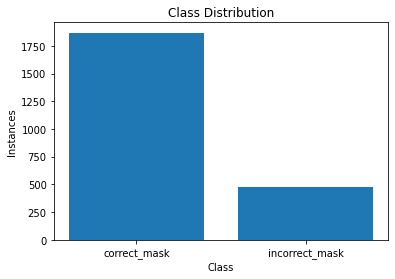

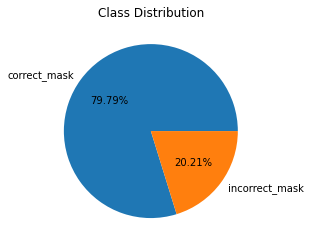

In [24]:
### Target class distribution ###

arr, counts = np.unique(df['class'], return_counts=True)
print('Total number of images:', len(df['image'].unique()))
print('Total number of faces:', len(df))
print('Class distribution:')
for i, cl in enumerate(arr):
  print('#'+cl+' = ', counts[i])
plt.figure()
plt.bar(arr, counts)
plt.xlabel('Class')
plt.ylabel('Instances')
plt.title('Class Distribution')
plt.figure()
plt.pie(counts, labels=arr, autopct='%1.2f%%')
plt.title('Class Distribution')

Text(0, 0.5, 'Frequency')

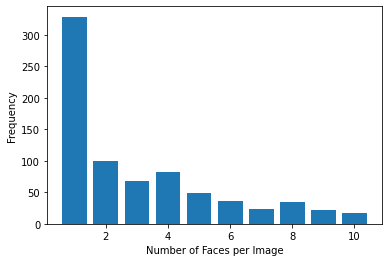

In [30]:
### Plot number of faces per image histogram ###
imgs, counts = np.unique(df['image'], return_counts = True)
arr, counts = np.unique(counts, return_counts = True)
plt.bar(arr, counts)
plt.xlabel('Number of Faces per Image')
plt.ylabel('Frequency')

# Train imbalanced Baseline CNN model

In [ ]:
### Crop ALL faces ###
start_time = time.time()
# Crop faces and save into a .npy file
face_images = []
y = []
for image_name in np.unique(df['image']):
  faces = df[df['image'] == image_name]
  full_image = img_to_array(load_img('drive/MyDrive/SML310 Final Project/images/'+image_name+'.png'))
  
  for idx in range(len(faces)): 
    face = faces.iloc[idx,:] # select face
    

    # crop face
    face_image = full_image[face['ymin']:face['ymax'], face['xmin']:face['xmax']]
    face_images.append(face_image)
    # append class label
    y.append(face['class'])

face_images = np.array(face_images)
y = np.array(y)

print('Cropped',len(face_images),'face images in ',time.time()-start_time,'seconds.')
np.save('face_images.npy', face_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Cropped 2340 face images in  14.803312540054321 seconds.


In [ ]:
### Resize each face to (40,40)
x = np.zeros((len(face_images), 40, 40, 3))
for i, face in enumerate(face_images):
  resized_face = tf.image.resize(face, (40,40))
  x[i, :, :, :] = resized_face

In [ ]:
### Ready training and testing data for keras model & Preprocess input
translate_labels = {'correct_mask':0, 'incorrect_mask':1}
int_y = []
for y_val in y:
  int_y.append(translate_labels[y_val])

xTrain, xTest, yTrain, yTest = train_test_split(x, int_y, test_size=0.2, random_state=42, stratify=int_y) # stratify by y to keep classes somewhat balanced
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42, stratify=yTrain)
 # Horizontal flip and random rotation for image augmentation, using data normalization too
data_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, horizontal_flip=True, rotation_range=30)
data_generator.fit(xTrain)
train_generator = data_generator.flow(xTrain, yTrain, batch_size=50)
test_generator = data_generator.flow(xTest, yTest, batch_size=1, shuffle=False)
val_generator = data_generator.flow(xVal, yVal, batch_size=50)

In [ ]:
### Define a keras CNN
model_CNN = keras.models.Sequential([
    keras.layers.Conv2D(filters = 16, kernel_size = (3,3),kernel_regularizer=l2(0.01), activation = 'relu', 
                        input_shape = (40,40,3)),
    keras.layers.Conv2D(filters = 16, kernel_size = (3,3),kernel_regularizer=l2(0.01), activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = (2,2)),
    keras.layers.Conv2D(filters = 32, kernel_size = (3,3),kernel_regularizer=l2(0.01), activation = 'relu'),
    keras.layers.Conv2D(filters = 64, kernel_size = (3,3),kernel_regularizer=l2(0.01), activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 64,kernel_regularizer=l2(0.01), activation='relu'),
    keras.layers.Dense(units = 1,kernel_regularizer=l2(0.01), activation = 'sigmoid')
])
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train model
history_CNN = model_CNN.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=val_generator)

Epoch 1/10
30/30 [==============================] - 6s 182ms/step - loss: 1.6589 - accuracy: 0.8250 - val_loss: 1.0613 - val_accuracy: 0.8853
Epoch 2/10
30/30 [==============================] - 5s 178ms/step - loss: 0.7681 - accuracy: 0.9105 - val_loss: 0.6643 - val_accuracy: 0.9040
Epoch 3/10
30/30 [==============================] - 5s 178ms/step - loss: 0.5349 - accuracy: 0.9272 - val_loss: 0.5400 - val_accuracy: 0.9147
Epoch 4/10
30/30 [==============================] - 5s 175ms/step - loss: 0.4426 - accuracy: 0.9285 - val_loss: 0.4546 - val_accuracy: 0.9067
Epoch 5/10
30/30 [==============================] - 5s 176ms/step - loss: 0.3784 - accuracy: 0.9359 - val_loss: 0.4233 - val_accuracy: 0.9147
Epoch 6/10
30/30 [==============================] - 5s 181ms/step - loss: 0.3629 - accuracy: 0.9279 - val_loss: 0.4040 - val_accuracy: 0.9173
Epoch 7/10
30/30 [==============================] - 5s 178ms/step - loss: 0.3341 - accuracy: 0.9385 - val_loss: 0.3563 - val_accuracy: 0.9200
Epoch 

AUC score =  0.975052913785805
Threshold maximizing tpr * tnr =  0.17378789
Corresponding (FPR,TPR) =  (0.06702412868632708, 0.9473684210526315)


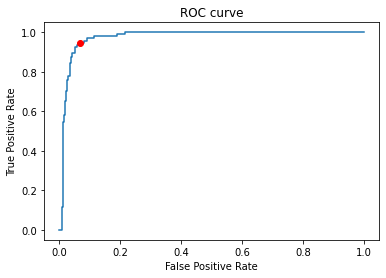

In [ ]:
### Create ROC curve
yPred = model_CNN.predict(test_generator, len(xTest))

fpr, tpr, thresholds = roc_curve(yTest, yPred)
best_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
plt.plot(fpr, tpr)
plt.plot(fpr[best_idx], tpr[best_idx], marker='o', color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('AUC score = ', roc_auc_score(yTest, yPred))
optimal_threshold = thresholds[best_idx]
print('Threshold maximizing tpr * tnr = ', optimal_threshold)
print('Corresponding (FPR,TPR) = ',(fpr[best_idx], tpr[best_idx]))

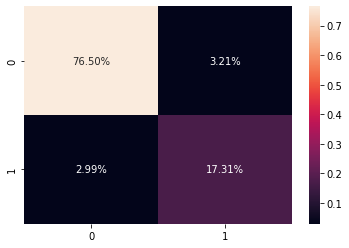

In [ ]:
# Test model and print confusion matrix under optimal threshold
threshold = optimal_threshold
yTestPred = (model_CNN.predict(xTest) >= threshold).astype('int')
test_matrix = confusion_matrix(yTest, yTestPred)

seaborn.heatmap(test_matrix/np.sum(test_matrix), annot=True, 
            fmt='.2%')

In [ ]:
tn, fp, fn, tp = test_matrix.ravel()
print('Accuracy = ', (tp+tn)/(tp+tn+fp+fn))
print('Precision = ', (tp)/(tp+fp))
print('Recall = ', (tp)/(tp+fn))

Accuracy =  0.938034188034188
Precision =  0.84375
Recall =  0.8526315789473684


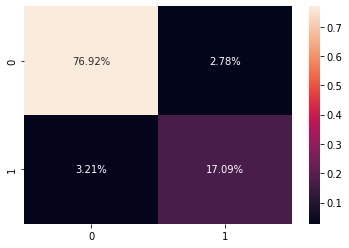

In [ ]:
# Test model and print confusion matrix under 0.5 threshold
threshold = 0.5
yTestPred = (model_CNN.predict(xTest) >= threshold).astype('int')
test_matrix = confusion_matrix(yTest, yTestPred)

seaborn.heatmap(test_matrix/np.sum(test_matrix), annot=True, 
            fmt='.2%')

In [ ]:
tn, fp, fn, tp = test_matrix.ravel()
print('Accuracy = ', (tp+tn)/(tp+tn+fp+fn))
print('Precision = ', (tp)/(tp+fp))
print('Recall = ', (tp)/(tp+fn))

Accuracy =  0.9401709401709402
Precision =  0.8602150537634409
Recall =  0.8421052631578947


Text(0, 0.5, 'Loss')

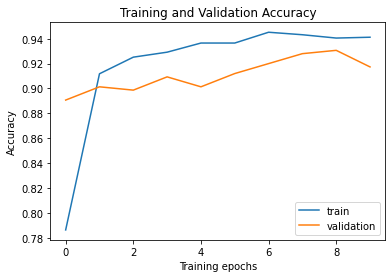

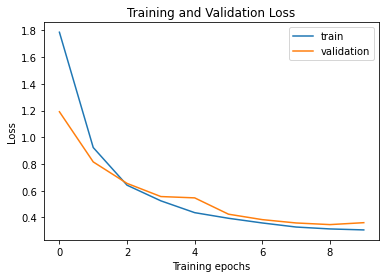

In [ ]:
### Plot training and validation accuracy and loss
plt.plot(history_CNN.history['accuracy'], label='train')
plt.plot(history_CNN.history['val_accuracy'], label ='validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Training epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history_CNN.history['loss'], label ='train')
plt.plot(history_CNN.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Training epochs')
plt.ylabel('Loss')

# Train imbalanced VGG19 model

In [ ]:
### Crop ALL faces ###
start_time = time.time()
# Crop faces and save into a .npy file
face_images = []
y = []
for image_name in np.unique(df['image']):
  faces = df[df['image'] == image_name]
  full_image = img_to_array(load_img('drive/MyDrive/SML310 Final Project/images/'+image_name+'.png'))
  
  for idx in range(len(faces)): 
    face = faces.iloc[idx,:] # select face

    # crop face
    face_image = full_image[face['ymin']:face['ymax'], face['xmin']:face['xmax']]
    face_images.append(face_image)
    # append class label
    y.append(face['class'])

face_images = np.array(face_images)
y = np.array(y)

print('Cropped',len(face_images),'face images in ',time.time()-start_time,'seconds.')
np.save('face_images.npy', face_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Cropped 2340 face images in  14.297337055206299 seconds.


In [ ]:
### Resize each face to (40,40)
x = np.zeros((len(face_images), 40, 40, 3))
for i, face in enumerate(face_images):
  resized_face = tf.image.resize(face, (40,40))
  x[i, :, :, :] = resized_face

In [ ]:
### Preprocess input
input = vgg19.preprocess_input(x.copy()) # use copy to not alter original x

In [ ]:
### Ready training and testing data for keras model
translate_labels = {'correct_mask':0, 'incorrect_mask':1}
int_y = []
for y_val in y:
  int_y.append(translate_labels[y_val])

xTrain, xTest, yTrain, yTest = train_test_split(input, int_y, test_size=0.2, random_state=42, stratify=int_y) # stratify by y to keep classes somewhat balanced
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42, stratify=yTrain)
data_generator = ImageDataGenerator(horizontal_flip=True, rotation_range=30) # Horizontal flip and random rotation for image augmentation
data_generator.fit(xTrain)
train_generator = data_generator.flow(xTrain, yTrain, batch_size=50)
test_generator = data_generator.flow(xTest, yTest, batch_size=1, shuffle=False)
val_generator = data_generator.flow(xVal, yVal, batch_size=10)

In [ ]:
### Define VGG19 transfer learning network
vgg19_network = VGG19(weights='imagenet',include_top=False,input_shape=(40,40,3))

for l in vgg19_network.layers:
    l.trainable = False

model_vgg19 = keras.models.Sequential([               
    vgg19_network,
    keras.layers.Flatten(),
    keras.layers.Dense(units = 100,kernel_regularizer=l2(0.02), activation = 'relu'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(units = 100,kernel_regularizer=l2(0.02), activation = 'relu'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(units = 100,kernel_regularizer=l2(0.02), activation = 'relu'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(units = 1,kernel_regularizer=l2(0.02), activation = 'sigmoid')
])

model_vgg19.compile(optimizer="adam",loss="binary_crossentropy",metrics ="accuracy")
# Train model
history_VGG19 = model_vgg19.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=val_generator)

Epoch 1/10
30/30 [==============================] - 38s 1s/step - loss: 7.3572 - accuracy: 0.7802 - val_loss: 6.1725 - val_accuracy: 0.8907
Epoch 2/10
30/30 [==============================] - 36s 1s/step - loss: 5.6744 - accuracy: 0.8758 - val_loss: 4.9962 - val_accuracy: 0.9120
Epoch 3/10
30/30 [==============================] - 37s 1s/step - loss: 4.6156 - accuracy: 0.9031 - val_loss: 4.1504 - val_accuracy: 0.9067
Epoch 4/10
30/30 [==============================] - 37s 1s/step - loss: 3.8343 - accuracy: 0.9085 - val_loss: 3.4883 - val_accuracy: 0.9307
Epoch 5/10
30/30 [==============================] - 36s 1s/step - loss: 3.2227 - accuracy: 0.9205 - val_loss: 2.9355 - val_accuracy: 0.9227
Epoch 6/10
30/30 [==============================] - 36s 1s/step - loss: 2.7107 - accuracy: 0.9299 - val_loss: 2.5159 - val_accuracy: 0.9333
Epoch 7/10
30/30 [==============================] - 37s 1s/step - loss: 2.3128 - accuracy: 0.9319 - val_loss: 2.1330 - val_accuracy: 0.9360
Epoch 8/10
30/30 [==

AUC score =  0.9589389022153239
Threshold maximizing tpr * tnr =  0.11672154
Corresponding (FPR,TPR) =  (0.0938337801608579, 0.8947368421052632)


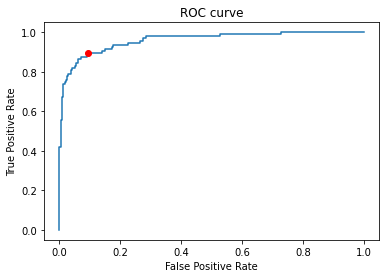

In [ ]:
### Create ROC curve
yPred = model_vgg19.predict(test_generator)

fpr, tpr, thresholds = roc_curve(yTest, yPred)
best_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
plt.plot(fpr, tpr)
plt.plot(fpr[best_idx], tpr[best_idx], marker='o', color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('AUC score = ', roc_auc_score(yTest, yPred))
optimal_threshold = thresholds[best_idx]
print('Threshold maximizing tpr * tnr = ', optimal_threshold)
print('Corresponding (FPR,TPR) = ',(fpr[best_idx], tpr[best_idx]))

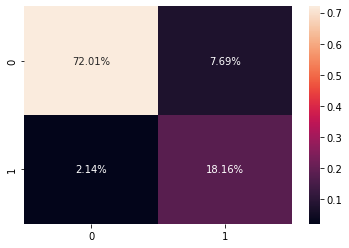

In [ ]:
# Test model and print confusion matrix under optimal threshold
threshold = optimal_threshold
yTestPred = (model_vgg19.predict(xTest) >= threshold).astype('int')
test_matrix = confusion_matrix(yTest, yTestPred)

seaborn.heatmap(test_matrix/np.sum(test_matrix), annot=True, 
            fmt='.2%')

In [ ]:
tn, fp, fn, tp = test_matrix.ravel()
print('Accuracy = ', (tp+tn)/(tp+tn+fp+fn))
print('Precision = ', (tp)/(tp+fp))
print('Recall = ', (tp)/(tp+fn))

Accuracy =  0.9017094017094017
Precision =  0.7024793388429752
Recall =  0.8947368421052632


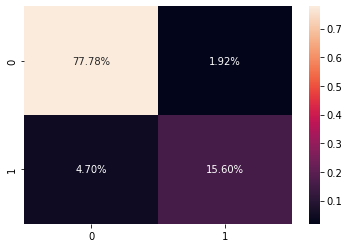

In [ ]:
# Test model and print confusion matrix under 0.5 threshold
threshold = 0.5
yTestPred = (model_vgg19.predict(xTest) >= threshold).astype('int')
test_matrix = confusion_matrix(yTest, yTestPred)

seaborn.heatmap(test_matrix/np.sum(test_matrix), annot=True, 
            fmt='.2%')

In [ ]:
tn, fp, fn, tp = test_matrix.ravel()
print('Accuracy = ', (tp+tn)/(tp+tn+fp+fn))
print('Precision = ', (tp)/(tp+fp))
print('Recall = ', (tp)/(tp+fn))

Accuracy =  0.9337606837606838
Precision =  0.8902439024390244
Recall =  0.7684210526315789


Text(0, 0.5, 'Loss')

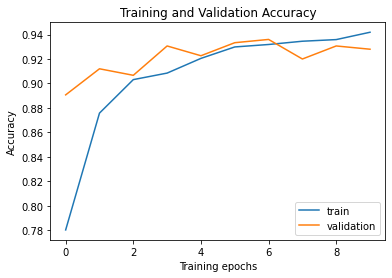

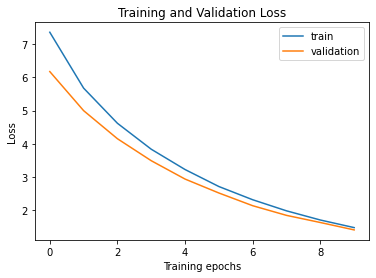

In [ ]:
### Plot training and validation accuracy and loss
plt.plot(history_VGG19.history['accuracy'], label='train')
plt.plot(history_VGG19.history['val_accuracy'], label ='validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Training epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history_VGG19.history['loss'], label ='train')
plt.plot(history_VGG19.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Training epochs')
plt.ylabel('Loss')

# Train Balanced Baseline CNN Model

In [14]:
### Crop ONLY 25% of correct_mask faces and ALL incorrect_mask faces to balance dataset
np.random.seed(42)
start_time = time.time()
# Crop faces and save into a .npy file
face_images = []
y = []
for image_name in np.unique(df['image']):
  faces = df[df['image'] == image_name]
  full_image = cv2.imread('drive/MyDrive/SML310 Final Project/images/'+image_name+'.png')
  for idx in range(len(faces)):
    face = faces.iloc[idx,:] # select face
    if face['class'] == 'correct_mask':
      if np.random.uniform() < 0.7: # skip 70% of correct_mask faces
        continue


    # crop face
    face_image = full_image[face['ymin']:face['ymax'], face['xmin']:face['xmax']]
    face_images.append(face_image)
    # append class label
    y.append(face['class'])

face_images = np.array(face_images)
y = np.array(y)

print('Cropped',len(face_images),'face images in ',time.time()-start_time,'seconds.')
np.save('face_images.npy', face_images)

Cropped 1029 face images in  14.579026937484741 seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [15]:
### Resize each face to (40,40)
x = np.zeros((len(face_images), 40, 40, 3))
for i, face in enumerate(face_images):
  resized_face = tf.image.resize(face, (40,40))
  x[i, :, :, :] = resized_face

In [16]:
### Ready training and testing data for keras model & Preprocess input
translate_labels = {'correct_mask':0, 'incorrect_mask':1}
int_y = []
for y_val in y:
  int_y.append(translate_labels[y_val])

xTrain, xTest, yTrain, yTest = train_test_split(x, int_y, test_size=0.2, random_state=42, stratify=int_y) # stratify by y to keep classes somewhat balanced

xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42, stratify=yTrain)
 # Horizontal flip and random rotation for image augmentation, using data normalization too
data_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, horizontal_flip=True, rotation_range=30)
data_generator.fit(xTrain)
train_generator = data_generator.flow(xTrain, yTrain, batch_size=50)
test_generator = data_generator.flow(xTest, yTest, batch_size=1, shuffle=False)
val_generator = data_generator.flow(xVal, yVal, batch_size=50)

In [17]:
### Define a keras CNN
model_CNN = keras.models.Sequential([
    keras.layers.Conv2D(filters = 16, kernel_size = (3,3),kernel_regularizer=l2(0.02), activation = 'relu', 
                        input_shape = (40,40,3)),
    keras.layers.Conv2D(filters = 16, kernel_size = (3,3),kernel_regularizer=l2(0.02), activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = (2,2)),
    keras.layers.Conv2D(filters = 32, kernel_size = (3,3),kernel_regularizer=l2(0.02), activation = 'relu'),
    keras.layers.Conv2D(filters = 64, kernel_size = (3,3),kernel_regularizer=l2(0.02), activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 64,kernel_regularizer=l2(0.01), activation='relu'),
    keras.layers.Dense(units = 1,kernel_regularizer=l2(0.01), activation = 'sigmoid')
])
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train model
history_CNN = model_CNN.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=val_generator)

Epoch 1/10
14/14 [==============================] - 4s 197ms/step - loss: 3.0170 - accuracy: 0.7204 - val_loss: 2.3654 - val_accuracy: 0.8606
Epoch 2/10
14/14 [==============================] - 3s 184ms/step - loss: 2.0067 - accuracy: 0.8678 - val_loss: 1.6837 - val_accuracy: 0.8667
Epoch 3/10
14/14 [==============================] - 3s 185ms/step - loss: 1.5151 - accuracy: 0.8708 - val_loss: 1.3449 - val_accuracy: 0.8909
Epoch 4/10
14/14 [==============================] - 3s 180ms/step - loss: 1.2266 - accuracy: 0.8997 - val_loss: 1.1544 - val_accuracy: 0.8848
Epoch 5/10
14/14 [==============================] - 3s 180ms/step - loss: 1.0343 - accuracy: 0.9134 - val_loss: 1.0208 - val_accuracy: 0.8848
Epoch 6/10
14/14 [==============================] - 3s 184ms/step - loss: 0.9165 - accuracy: 0.9225 - val_loss: 0.9333 - val_accuracy: 0.8909
Epoch 7/10
14/14 [==============================] - 3s 181ms/step - loss: 0.8293 - accuracy: 0.9255 - val_loss: 0.8740 - val_accuracy: 0.8848
Epoch 

AUC score =  0.9799905168326222
Threshold maximizing tpr * tnr =  0.31331155
Corresponding (FPR,TPR) =  (0.08108108108108109, 0.9789473684210527)


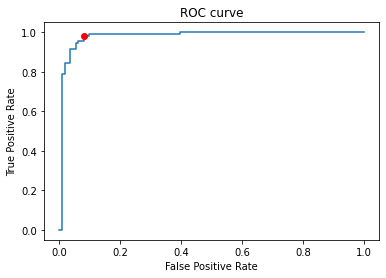

In [18]:
### Create ROC curve
yPred = model_CNN.predict(test_generator, len(xTest))

fpr, tpr, thresholds = roc_curve(yTest, yPred)
best_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
plt.plot(fpr, tpr)
plt.plot(fpr[best_idx], tpr[best_idx], marker='o', color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('AUC score = ', roc_auc_score(yTest, yPred))
optimal_threshold = thresholds[best_idx]
print('Threshold maximizing tpr * tnr = ', optimal_threshold)
print('Corresponding (FPR,TPR) = ',(fpr[best_idx], tpr[best_idx]))

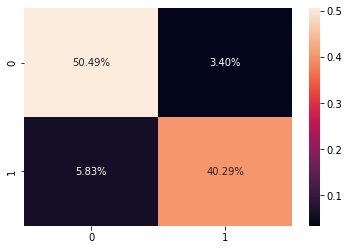

In [19]:
# Test model and print confusion matrix under optimal threshold
threshold = optimal_threshold
yTestPred = (model_CNN.predict(xTest) >= threshold).astype('int')
test_matrix = confusion_matrix(yTest, yTestPred)

seaborn.heatmap(test_matrix/np.sum(test_matrix), annot=True, 
            fmt='.2%')

In [20]:
tn, fp, fn, tp = test_matrix.ravel()
print('Accuracy = ', (tp+tn)/(tp+tn+fp+fn))
print('Precision = ', (tp)/(tp+fp))
print('Recall = ', (tp)/(tp+fn))

Accuracy =  0.9077669902912622
Precision =  0.9222222222222223
Recall =  0.8736842105263158


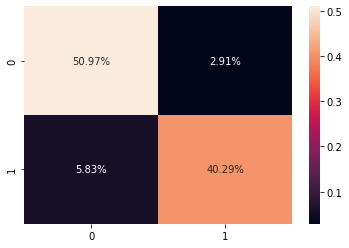

In [21]:
# Test model and print confusion matrix under 0.5 threshold
threshold = 0.5
yTestPred = (model_CNN.predict(xTest) >= threshold).astype('int')
test_matrix = confusion_matrix(yTest, yTestPred)

seaborn.heatmap(test_matrix/np.sum(test_matrix), annot=True, 
            fmt='.2%')

In [22]:
tn, fp, fn, tp = test_matrix.ravel()
print('Accuracy = ', (tp+tn)/(tp+tn+fp+fn))
print('Precision = ', (tp)/(tp+fp))
print('Recall = ', (tp)/(tp+fn))

Accuracy =  0.912621359223301
Precision =  0.9325842696629213
Recall =  0.8736842105263158


Text(0, 0.5, 'Loss')

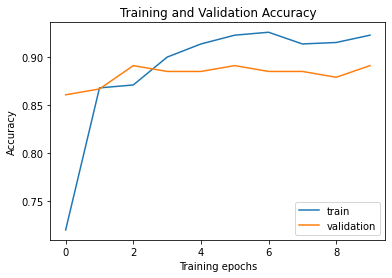

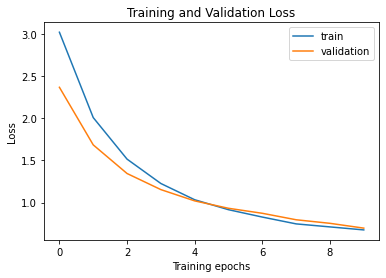

In [23]:
### Plot training and validation accuracy and loss
plt.plot(history_CNN.history['accuracy'], label='train')
plt.plot(history_CNN.history['val_accuracy'], label ='validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Training epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history_CNN.history['loss'], label ='train')
plt.plot(history_CNN.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Training epochs')
plt.ylabel('Loss')

# Train Balanced VGG19 Model

In [ ]:
### Crop ONLY 25% of correct_mask faces and ALL incorrect_mask faces to balance dataset
np.random.seed(42)
start_time = time.time()
# Crop faces and save into a .npy file
face_images = []
y = []
for image_name in np.unique(df['image']):
  faces = df[df['image'] == image_name]
  full_image = cv2.imread('drive/MyDrive/SML310 Final Project/images/'+image_name+'.png')
  for idx in range(len(faces)):
    face = faces.iloc[idx,:] # select face
    if face['class'] == 'correct_mask':
      if np.random.uniform() < 0.7: # skip 70% of correct_mask faces
        continue
    
    # crop face
    face_image = full_image[face['ymin']:face['ymax'], face['xmin']:face['xmax']]
    face_images.append(face_image)
    # append class label
    y.append(face['class'])

face_images = np.array(face_images)
y = np.array(y)

print('Cropped',len(face_images),'face images in ',time.time()-start_time,'seconds.')
np.save('face_images.npy', face_images)

Cropped 1029 face images in  12.705406188964844 seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
### Resize each face to (40,40)
x = np.zeros((len(face_images), 40, 40, 3))
for i, face in enumerate(face_images):
  resized_face = tf.image.resize(face, (40,40))
  x[i, :, :, :] = resized_face

In [ ]:
### Preprocess input
input = vgg19.preprocess_input(x.copy())

In [ ]:
### Ready training and testing data for keras model
translate_labels = {'correct_mask':0, 'incorrect_mask':1}
int_y = []
for y_val in y:
  int_y.append(translate_labels[y_val])

xTrain, xTest, yTrain, yTest = train_test_split(input, int_y, test_size=0.2, random_state=42, stratify=int_y) # stratify by y to keep classes somewhat balanced
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42, stratify=yTrain)
data_generator = ImageDataGenerator(horizontal_flip=True, rotation_range=30) # Horizontal flip and random rotation for image augmentation
data_generator.fit(xTrain)
train_generator = data_generator.flow(xTrain, yTrain, batch_size=50)
test_generator = data_generator.flow(xTest, yTest, batch_size=1, shuffle=False)
val_generator = data_generator.flow(xVal, yVal, batch_size=50)

In [ ]:
### Define VGG19 transfer learning network
vgg19_network = VGG19(weights='imagenet',include_top=False,input_shape=(40,40,3))

for l in vgg19_network.layers:
    l.trainable = False

model_vgg19 = keras.models.Sequential([               
    vgg19_network,
    keras.layers.Flatten(),
    keras.layers.Dense(units = 100,kernel_regularizer=l2(0.01), activation = 'relu'),
    keras.layers.Dropout(.1),
    keras.layers.Dense(units = 100,kernel_regularizer=l2(0.01), activation = 'relu'),
    keras.layers.Dropout(.1),
    keras.layers.Dense(units = 100,kernel_regularizer=l2(0.01), activation = 'relu'),
    keras.layers.Dropout(.1),
    keras.layers.Dense(units = 1,kernel_regularizer=l2(0.01), activation = 'sigmoid')
])

model_vgg19.compile(optimizer="adam",loss="binary_crossentropy",metrics ="accuracy")
# Train model
history_VGG19 = model_vgg19.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=val_generator)

Epoch 1/10
14/14 [==============================] - 17s 1s/step - loss: 4.5787 - accuracy: 0.6413 - val_loss: 3.9154 - val_accuracy: 0.7939
Epoch 2/10
14/14 [==============================] - 16s 1s/step - loss: 3.9658 - accuracy: 0.7401 - val_loss: 3.8626 - val_accuracy: 0.7455
Epoch 3/10
14/14 [==============================] - 16s 1s/step - loss: 3.6002 - accuracy: 0.7766 - val_loss: 3.4503 - val_accuracy: 0.7879
Epoch 4/10
14/14 [==============================] - 16s 1s/step - loss: 3.3591 - accuracy: 0.8009 - val_loss: 3.2387 - val_accuracy: 0.8303
Epoch 5/10
14/14 [==============================] - 16s 1s/step - loss: 3.0838 - accuracy: 0.8465 - val_loss: 3.0476 - val_accuracy: 0.8364
Epoch 6/10
14/14 [==============================] - 16s 1s/step - loss: 2.9959 - accuracy: 0.8359 - val_loss: 2.9019 - val_accuracy: 0.8182
Epoch 7/10
14/14 [==============================] - 16s 1s/step - loss: 2.8010 - accuracy: 0.8556 - val_loss: 2.7370 - val_accuracy: 0.8606
Epoch 8/10
14/14 [==

AUC score =  0.9232811759127548
Threshold maximizing tpr * tnr =  0.641482
Corresponding (FPR,TPR) =  (0.06306306306306306, 0.8105263157894737)


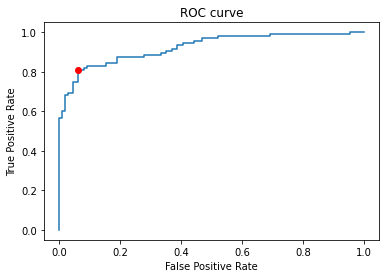

In [ ]:
### Create ROC curve
yPred = model_vgg19.predict(test_generator)

fpr, tpr, thresholds = roc_curve(yTest, yPred)
best_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
plt.plot(fpr, tpr)
plt.plot(fpr[best_idx], tpr[best_idx], marker='o', color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('AUC score = ', roc_auc_score(yTest, yPred))
optimal_threshold = thresholds[best_idx]
print('Threshold maximizing tpr * tnr = ', optimal_threshold)
print('Corresponding (FPR,TPR) = ',(fpr[best_idx], tpr[best_idx]))

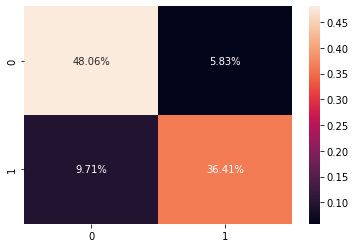

In [ ]:
# Test model and print confusion matrix under optimal threshold
threshold = optimal_threshold
yTestPred = (model_vgg19.predict(test_generator) >= threshold).astype('int')
test_matrix = confusion_matrix(yTest, yTestPred)

seaborn.heatmap(test_matrix/np.sum(test_matrix), annot=True, 
            fmt='.2%')

In [ ]:
tn, fp, fn, tp = test_matrix.ravel()
print('Accuracy = ', (tp+tn)/(tp+tn+fp+fn))
print('Precision = ', (tp)/(tp+fp))
print('Recall = ', (tp)/(tp+fn))

Accuracy =  0.8446601941747572
Precision =  0.8620689655172413
Recall =  0.7894736842105263


In [ ]:
# Test model and print confusion matrix under 0.5 threshold
threshold = 0.5
yTestPred = (model_vgg19.predict(xTest) >= threshold).astype('int')
test_matrix = confusion_matrix(yTest, yTestPred)

seaborn.heatmap(test_matrix/np.sum(test_matrix), annot=True, 
            fmt='.2%')

In [ ]:
tn, fp, fn, tp = test_matrix.ravel()
print('Accuracy = ', (tp+tn)/(tp+tn+fp+fn))
print('Precision = ', (tp)/(tp+fp))
print('Recall = ', (tp)/(tp+fn))

Text(0, 0.5, 'Loss')

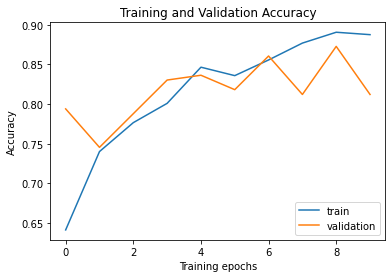

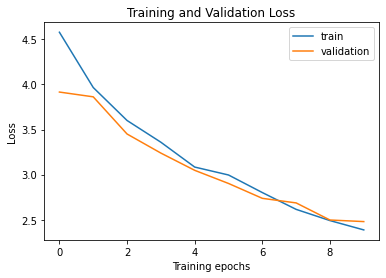

In [ ]:
### Plot training and validation accuracy and loss
plt.plot(history_VGG19.history['accuracy'], label='train')
plt.plot(history_VGG19.history['val_accuracy'], label ='validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Training epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history_VGG19.history['loss'], label ='train')
plt.plot(history_VGG19.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Training epochs')
plt.ylabel('Loss')

In [ ]:
### Retrain last 2 Convolutional layers in VGG19
retrain_layers = ['block5_conv4', 'block5_conv3'] # Final 2 conv layers in VGG19

vgg19_network = VGG19(weights='imagenet',include_top=False,input_shape=(40,40,3))

for l in vgg19_network.layers:
  l.trainable = False

for l in retrain_layers:
  vgg19_network.get_layer(l).trainable=True

model_vgg19 = keras.models.Sequential([               
    vgg19_network,
    keras.layers.Flatten(),
    keras.layers.Dense(units = 100,kernel_regularizer=l2(0.01), activation = 'relu'),
    keras.layers.Dropout(.1),
    keras.layers.Dense(units = 100,kernel_regularizer=l2(0.01), activation = 'relu'),
    keras.layers.Dropout(.1),
    keras.layers.Dense(units = 100,kernel_regularizer=l2(0.01), activation = 'relu'),
    keras.layers.Dropout(.1),
    keras.layers.Dense(units = 1,kernel_regularizer=l2(0.01), activation = 'sigmoid')
])

model_vgg19.compile(optimizer="adam",loss="binary_crossentropy",metrics ="accuracy")
# Train model
history_VGG19 = model_vgg19.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=val_generator)

Epoch 1/10
14/14 [==============================] - 28s 2s/step - loss: 5.3458 - accuracy: 0.6717 - val_loss: 4.6545 - val_accuracy: 0.8242
Epoch 2/10
14/14 [==============================] - 27s 2s/step - loss: 4.0757 - accuracy: 0.8040 - val_loss: 3.5274 - val_accuracy: 0.8727
Epoch 3/10
14/14 [==============================] - 26s 2s/step - loss: 3.2651 - accuracy: 0.8921 - val_loss: 3.2183 - val_accuracy: 0.8545
Epoch 4/10
14/14 [==============================] - 27s 2s/step - loss: 2.9319 - accuracy: 0.8739 - val_loss: 2.9511 - val_accuracy: 0.8485
Epoch 5/10
14/14 [==============================] - 26s 2s/step - loss: 2.6935 - accuracy: 0.8906 - val_loss: 2.5917 - val_accuracy: 0.8727
Epoch 6/10
14/14 [==============================] - 26s 2s/step - loss: 2.4888 - accuracy: 0.9103 - val_loss: 2.5545 - val_accuracy: 0.8606
Epoch 7/10
14/14 [==============================] - 26s 2s/step - loss: 2.3198 - accuracy: 0.9255 - val_loss: 2.4138 - val_accuracy: 0.8848
Epoch 8/10
14/14 [==

AUC score =  0.9624466571834993
Threshold maximizing tpr * tnr =  0.575071
Corresponding (FPR,TPR) =  (0.07207207207207207, 0.8842105263157894)


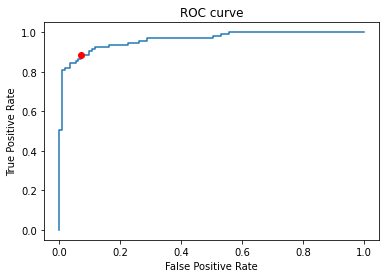

In [ ]:
### Create ROC curve
yPred = model_vgg19.predict(test_generator)

fpr, tpr, thresholds = roc_curve(yTest, yPred)
best_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
plt.plot(fpr, tpr)
plt.plot(fpr[best_idx], tpr[best_idx], marker='o', color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('AUC score = ', roc_auc_score(yTest, yPred))
optimal_threshold = thresholds[best_idx]
print('Threshold maximizing tpr * tnr = ', optimal_threshold)
print('Corresponding (FPR,TPR) = ',(fpr[best_idx], tpr[best_idx]))

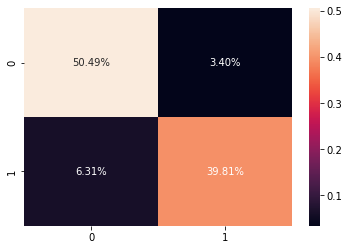

In [ ]:
# Test model and print confusion matrix under optimal threshold
threshold = optimal_threshold
yTestPred = (model_vgg19.predict(test_generator) >= threshold).astype('int')
test_matrix = confusion_matrix(yTest, yTestPred)

seaborn.heatmap(test_matrix/np.sum(test_matrix), annot=True, 
            fmt='.2%')

In [ ]:
tn, fp, fn, tp = test_matrix.ravel()
print('Accuracy = ', (tp+tn)/(tp+tn+fp+fn))
print('Precision = ', (tp)/(tp+fp))
print('Recall = ', (tp)/(tp+fn))

Accuracy =  0.9029126213592233
Precision =  0.9213483146067416
Recall =  0.8631578947368421


Text(0, 0.5, 'Loss')

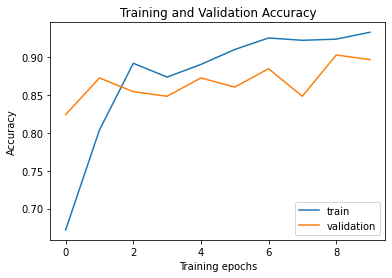

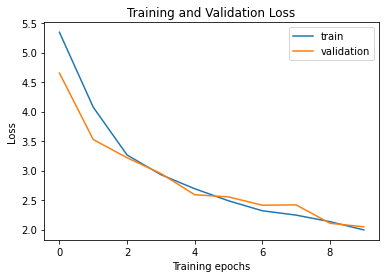

In [ ]:
### Plot training and validation accuracy and loss
plt.plot(history_VGG19.history['accuracy'], label='train')
plt.plot(history_VGG19.history['val_accuracy'], label ='validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Training epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history_VGG19.history['loss'], label ='train')
plt.plot(history_VGG19.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Training epochs')
plt.ylabel('Loss')

# Random Forest Model

In [ ]:
### Extract features using VGG19
vgg19_network = VGG19(weights='imagenet',include_top=False,input_shape=(40,40,3))
xTrainRF = vgg19_network.predict(xTrain)
xTestRF = vgg19_network.predict(xTest)

In [ ]:
### Reshape data to be fitted by a Random Forest Classifier
xTrainRF = xTrainRF.reshape(xTrainRF.shape[0],xTrainRF.shape[-1])
xTestRF = xTestRF.reshape(xTestRF.shape[0],xTestRF.shape[-1])

In [ ]:
from sklearn.model_selection import cross_val_score

for max_depth in [1,2,3,4,5,6,7,8,9,10,11,12,13]:
 print('------------------------------------------------------------------')
 print('max_depth =',max_depth)
 rf = RandomForestClassifier(max_depth=max_depth)
 accuracy = np.mean(cross_val_score(rf, xTrainRF, yTrain, cv=5, scoring='accuracy'))
 precision = np.mean(cross_val_score(rf, xTrainRF, yTrain, cv=5, scoring='precision'))
 recall = np.mean(cross_val_score(rf, xTrainRF, yTrain, cv=5, scoring='recall'))
 print('Train accuracy = ', round(accuracy, 3))
 print('Precision on train data = ', round(precision, 3))
 print('Recall on train data = ', round(recall, 3))

------------------------------------------------------------------
max_depth = 1
Train accuracy =  0.708
Precision on train data =  0.904
Recall on train data =  0.414
------------------------------------------------------------------
max_depth = 2
Train accuracy =  0.77
Precision on train data =  0.89
Recall on train data =  0.593
------------------------------------------------------------------
max_depth = 3
Train accuracy =  0.812
Precision on train data =  0.868
Recall on train data =  0.675
------------------------------------------------------------------
max_depth = 4
Train accuracy =  0.825
Precision on train data =  0.847
Recall on train data =  0.719
------------------------------------------------------------------
max_depth = 5
Train accuracy =  0.822
Precision on train data =  0.867
Recall on train data =  0.732
------------------------------------------------------------------
max_depth = 6
Train accuracy =  0.836
Precision on train data =  0.864
Recall on train data =  

Accuracy =  0.8495145631067961
Precision =  0.9102564102564102
Recall =  0.7473684210526316


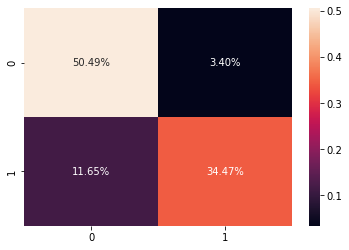

In [ ]:
### Selected RF classifier with max_depth = 7
rf = RandomForestClassifier(max_depth=7).fit(xTrainRF, yTrain)
yTestPred = rf.predict(xTestRF)
test_matrix = confusion_matrix(yTest, yTestPred)
tn, fp, fn, tp = test_matrix.ravel()
print('Accuracy = ', (tp+tn)/(tp+tn+fp+fn))
print('Precision = ', (tp)/(tp+fp))
print('Recall = ', (tp)/(tp+fn))

seaborn.heatmap(test_matrix/np.sum(test_matrix), annot=True, 
            fmt='.2%')